In [1]:
!pip3 install pytorch-forecasting

import sys
# sys.path.append('../../pytorch-forecasting')
sys.path.append("../")
import matplotlib.pyplot as plt
import pandas as pd
import torch

from data_factory.DataLoader import DataLoader
from utils.utils import load_config
# evaluation file
from utils.evaluation import label_evaluation

from tqdm.notebook import tqdm
import seaborn as sns

In [2]:
config_file = "../config/config.yml"
config = load_config(config_file)

result_file = '../predict.csv'
truth_file = '../ground_truth.hdf'

In [3]:
dl = DataLoader(use_previous_files=False, config_file=config_file)

dl.train.authentic = dl.train.authentic.astype(str)
dl.test.authentic = dl.test.authentic.astype(str)
dl.val.authentic = dl.val.authentic.astype(str)

INFO:data_factory.DataLoader:../data/train.csv loaded. shape (2476315, 4)
INFO:data_factory.DataLoader:../data/test.csv loaded. shape (2345211, 3)
INFO:data_factory.DataLoader:Preprocessing done.
INFO:data_factory.DataLoader:Data exported to "../data//data_export_train.csv_test.csv_fmd-True_True_False_0.95.p"


## Feature Engineering

In [4]:
normal_train = dl.train[dl.train.label == 0].drop(labels='label', axis=1)
normal_val = dl.val[dl.val.label == 0].drop(labels='label', axis=1)
normal_train.shape, normal_val.shape

((2604161, 7), (131019, 7))

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(18, 3))

f = normal_train.kpi_id == normal_train.kpi_id.unique()[0]
axs[0].plot(normal_train[f].timestamp, normal_train[f].value)
axs[0].set_xlim(1495e6, 1496e6)
f = dl.train.kpi_id == dl.train.kpi_id.unique()[0]

axs[1].plot(dl.train[f].timestamp, dl.train[f].value)
axs[1].set_xlim(1495e6, 1496e6)

In [6]:
from data_factory.preprocessing import *

normal_train = fill_missing_dates(
    normal_train, date_col="datetime", timestamp_col="timestamp", grp_col="kpi_id"
).copy()
normal_train['timestamp_1'] = (normal_train.timestamp / 60).astype(int)
normal_train.authentic = normal_train.authentic.astype(str)

normal_val = fill_missing_dates(
    normal_val, date_col="datetime", timestamp_col="timestamp", grp_col="kpi_id"
).copy()
normal_val['timestamp_1'] = (normal_val.timestamp / 60).astype(int)
normal_val.authentic = normal_val.authentic.astype(str)

max_prediction_length = 1
max_encoder_length = config['LinearAutoEncoder']['max_seq_len']
min_encoder_length = config['LinearAutoEncoder']['min_seq_len']

In [7]:
kpi_id_ref = normal_train.kpi_id.unique()[0]

X_cols = ['value_scaled', 'kpi_id', 'timestamp_1', 'authentic']
normal_train = normal_train.reset_index(drop=True)
normal_val = normal_val.reset_index(drop=True)

In [8]:
from pytorch_forecasting import TimeSeriesDataSet

training = TimeSeriesDataSet(
    normal_train.loc[:, X_cols],
    time_idx='timestamp_1', target='value_scaled',
    group_ids=['kpi_id'],
    allow_missing_timesteps=False,
    static_categoricals=['kpi_id', 'authentic'],
    time_varying_unknown_reals=['value_scaled'],
    max_encoder_length=max_encoder_length,
    min_encoder_length=min_encoder_length,
    max_prediction_length=max_prediction_length,
    scalers={col: None for col in ['timestamp_1', 'kpi_id']},
    target_normalizer=None,
    add_relative_time_idx=False,
    add_target_scales=False,
    add_encoder_length=False,
)

validation = TimeSeriesDataSet.from_dataset(
    training, normal_val.loc[:, X_cols],
    stop_randomization=True,
    predict=False
)
testing = TimeSeriesDataSet.from_dataset(
    training, dl.test,
    stop_randomization=True,
    predict=False,
    min_encoder_length=max_encoder_length
)

In [10]:
batch_size = 64

training_dl = training.to_dataloader(train=True, batch_size=batch_size, num_workers=12)
validation_dl = validation.to_dataloader(train=False, batch_size=batch_size*2, num_workers=12)
testing_dl = testing.to_dataloader(train=False, batch_size=batch_size * 3, num_workers=12)

## Model

In [11]:
from models.LitAutoencoder import LitAE

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using", device)
n_features = 1
n_dim = config['LinearAutoEncoder']['in_features']

Using cuda


In [13]:
model = LitAE(input_shape=max_encoder_length, n_dim=n_dim)
# model = LitAE.load_from_checkpoint("./lightning_logs/version_1/checkpoints/epoch=4-step=171145.ckpt",
#                                    input_shape=max_encoder_length, n_dim=n_dim)


INFO:torch.distributed.nn.jit.instantiator:Created a temporary directory at /tmp/tmpm29pkywq
INFO:torch.distributed.nn.jit.instantiator:Writing /tmp/tmpm29pkywq/_remote_module_non_sriptable.py


In [14]:
from pytorch_lightning.callbacks import EarlyStopping
from pytorch_lightning.trainer import Trainer

ea = EarlyStopping(
    monitor='val_loss',
    patience=1,
    mode='min',
    verbose=True,
)

trainer = Trainer(
    logger=True,
    enable_checkpointing=True,
    callbacks=[ea],
    gpus=1,
    auto_lr_find=True,
    max_epochs=-1
)

trainer.validate(model=model, dataloaders=validation_dl)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True, used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.gpu:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: 0it [00:00, ?it/s]

/home/cyprien/anaconda3/envs/pytorch/lib/python3.8/site-packages/pytorch_lightning/utilities/data.py:72: UserWarning: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 128. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
  warning_cache.warn(


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     val_loss_epoch           40786.33203125
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


/home/cyprien/anaconda3/envs/pytorch/lib/python3.8/site-packages/pytorch_lightning/utilities/data.py:72: UserWarning: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 75. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
  warning_cache.warn(


[{'val_loss_epoch': 40786.33203125}]

In [15]:
trainer.fit(model=model, train_dataloaders=training_dl, val_dataloaders=validation_dl)

INFO:pytorch_lightning.accelerators.gpu:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name                 | Type   | Params
------------------------------------------------
0 | encoder_hidden_layer | Linear | 32.1 K
1 | encoder_output_layer | Linear | 4.2 K 
2 | decoder_hidden_layer | Linear | 4.2 K 
3 | decoder_output_layer | Linear | 32.5 K
------------------------------------------------
72.9 K    Trainable params
0         Non-trainable params
72.9 K    Total params
0.292     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved. New best score: 5210.236


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 680.022 >= min_delta = 0.0. New best score: 4530.214


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 68.273 >= min_delta = 0.0. New best score: 4461.941


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 5.244 >= min_delta = 0.0. New best score: 4456.697


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.750 >= min_delta = 0.0. New best score: 4455.947


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.125 >= min_delta = 0.0. New best score: 4455.822


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 4455.821


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 4455.820


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Monitored metric val_loss did not improve in the last 1 records. Best score: 4455.820. Signaling Trainer to stop.


In [16]:
trainer.validate(model=model, dataloaders=validation_dl)

# trainer.test(model)
# trainer.predict(model)

INFO:pytorch_lightning.accelerators.gpu:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     val_loss_epoch          4455.82080078125
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'val_loss_epoch': 4455.82080078125}]

## Predict abnormal value

In [18]:
def predict(df_: pd.DataFrame):
    df_['timestamp_1_floor'] = df_.groupby('kpi_id').timestamp_1.transform(lambda x: x - x.min())
    pv = pd.pivot_table(df_, values='value_scaled', index='timestamp_1_floor', columns='kpi_id', fill_value=np.nan)

    ept = np.empty(max_encoder_length)
    ept[:] = np.nan

    pv = pd.concat([pv, pd.DataFrame({col: ept.copy() for col in pv.columns})])

    pv_forward = np.moveaxis(pv.copy().to_numpy(dtype=np.float32), 1, 0)
    pv_filter = np.moveaxis(pv.copy().to_numpy(), 1, 0)
    pv_forward[np.isnan(pv_forward)] = 0
    pv_filter = np.where(np.isnan(pv_filter), 0, 1)

    df_['value_pred'] = np.nan

    for i in tqdm(np.arange(0, pv.index.max() + 1, max_encoder_length)):
        pv_forward_i = pv_forward[:, i:i + max_encoder_length]
        pv_filter_i = pv_filter[:, i:i + max_encoder_length]

        X = torch.from_numpy(pv_forward_i.copy())
        y_pred = model(X)

        validation_filter = df_.groupby('kpi_id').apply(
            lambda x: (x.timestamp_1_floor >= i) & (x.timestamp_1_floor < i + max_encoder_length)).reset_index(
            drop=True)

        df_.loc[validation_filter, 'value_pred'] = y_pred.cpu().detach().numpy()[pv_filter_i.astype(bool)].flatten()


predict(dl.train)
predict(dl.test)
predict(dl.val)

  0%|          | 0/16 [00:00<?, ?it/s]

In [25]:
def predict_label(df_: pd.DataFrame):
    df_['label_pred'] = np.nan

    for kpi_id in tqdm(df_.kpi_id.unique()):
        df_f = df_[(df_.kpi_id == kpi_id)]
        THRESHOLD = np.abs(df_f.value_pred - df_f.value_scaled).quantile(.991)  # .991
        df_.loc[(df_.kpi_id == kpi_id), 'label_pred'] = np.abs(df_f.value_pred - df_f.value_scaled) > THRESHOLD


predict_label(dl.train)
predict_label(dl.test)
predict_label(dl.val)

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

#### Plot results

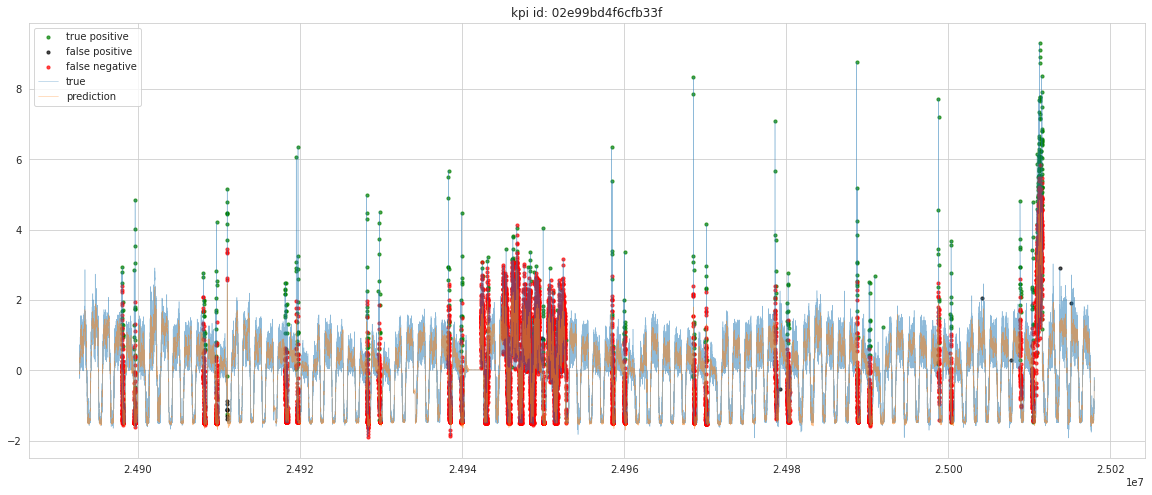

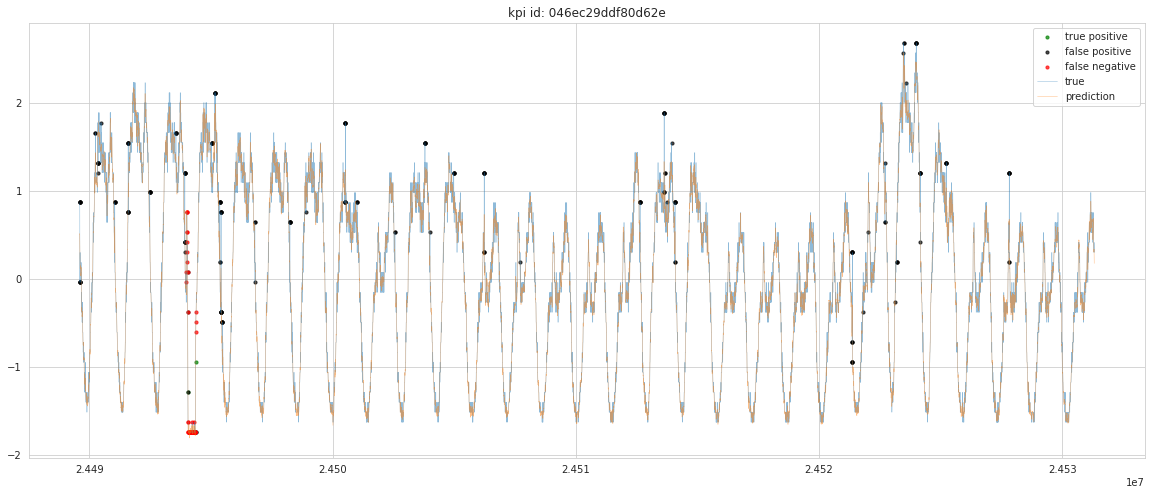

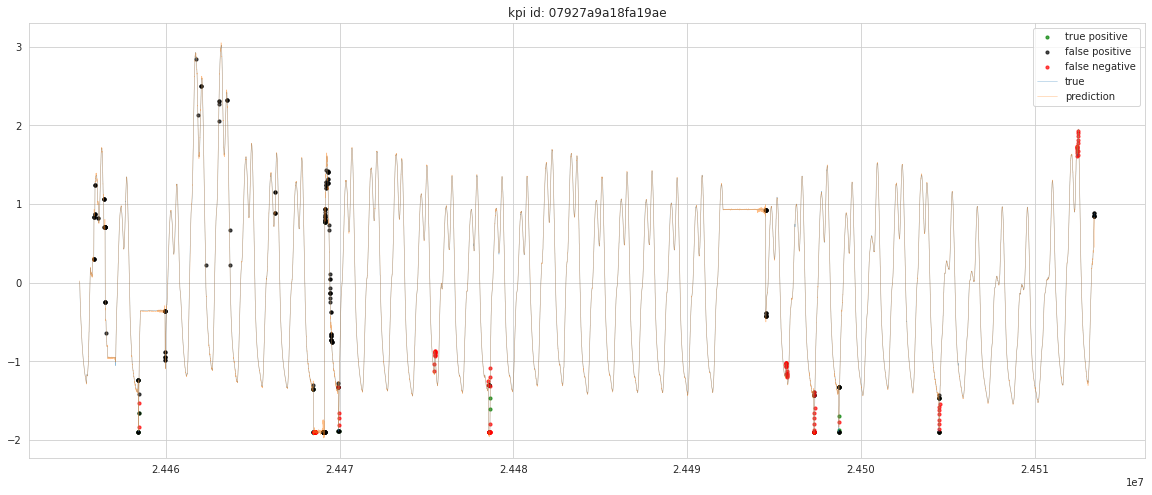

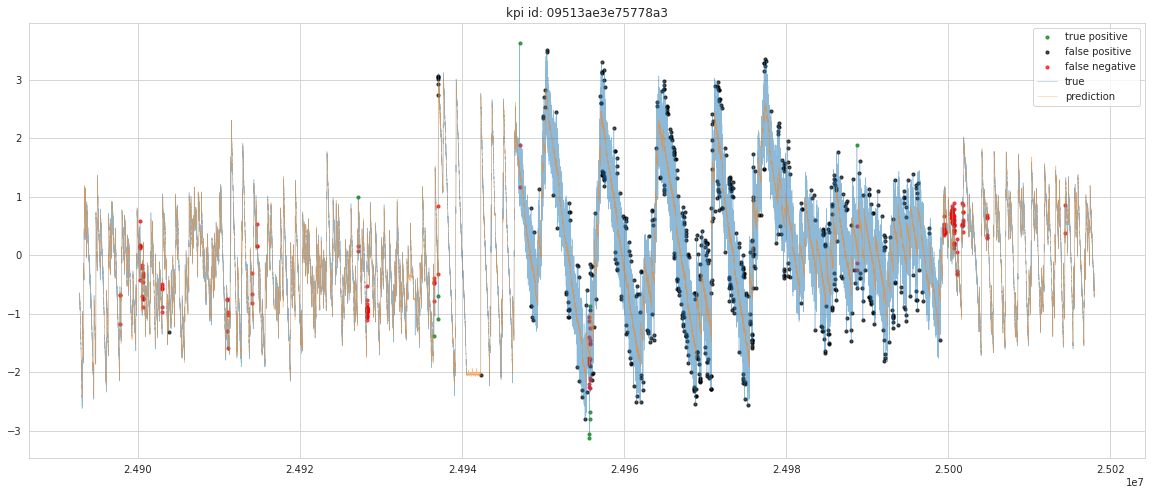

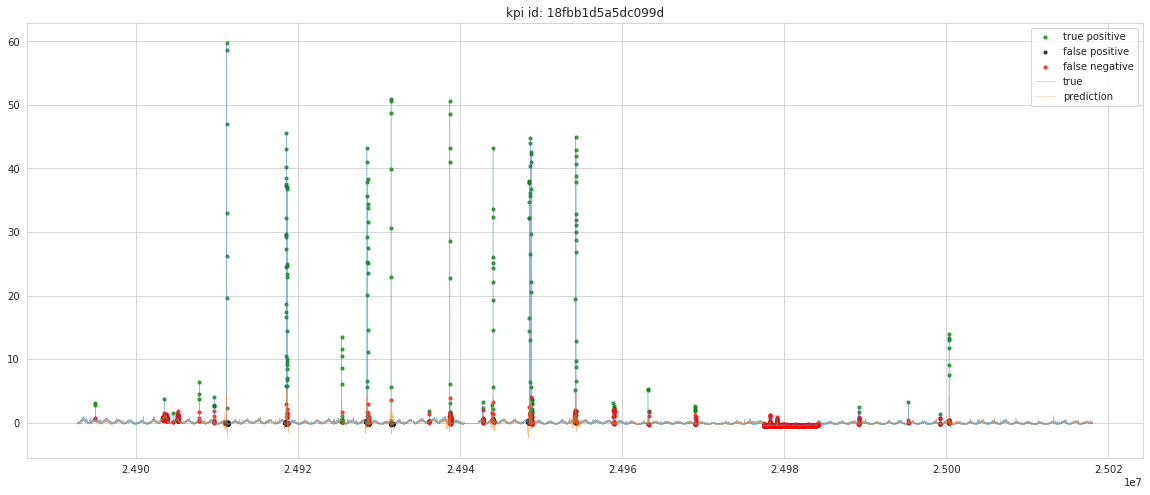

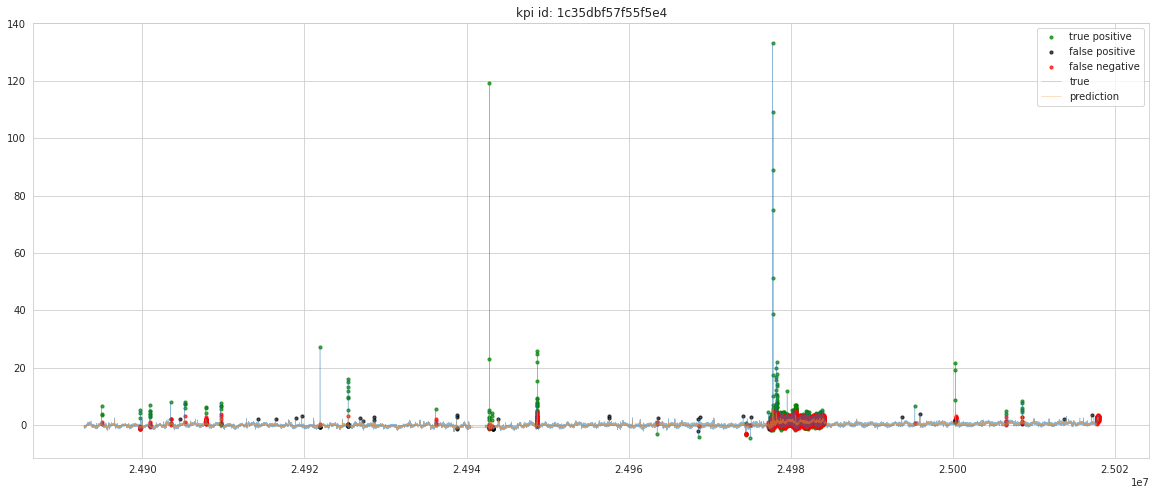

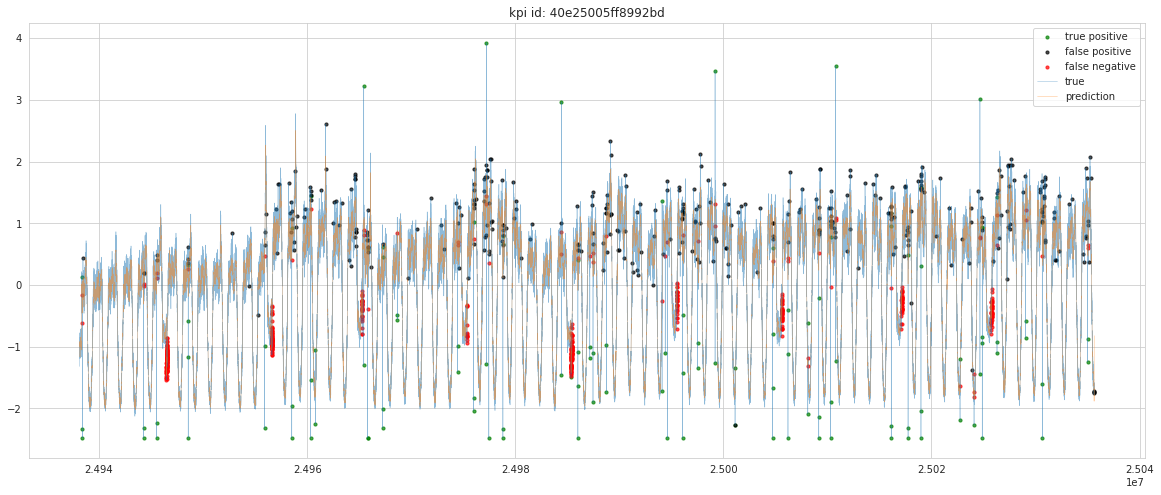

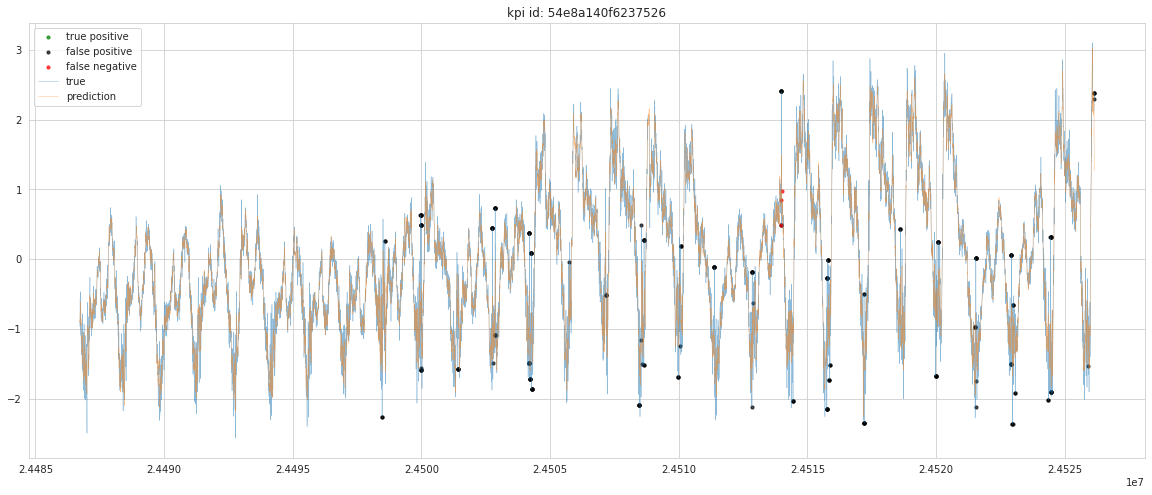

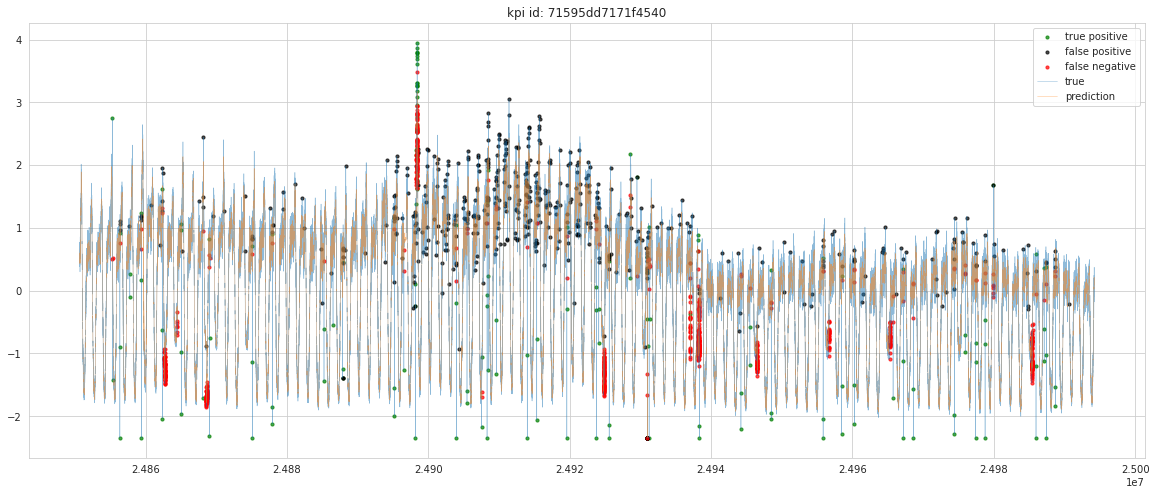

In [24]:
import logging
from logging import WARNING

logging.basicConfig(level=WARNING)
sns.set_style("whitegrid")

for kpi_id in dl.train.kpi_id.unique()[:9]:
    df = dl.train[(dl.train.kpi_id == kpi_id)]

    true_positive = ((df.label == 1) & (df.label_pred == 1))
    false_positive = ((df.label == 0) & (df.label_pred == 1))
    false_negative = ((df.label == 1) & (df.label_pred == 0))

    figure = plt.figure(figsize=(20, 8))
    for filter, color, label in zip([true_positive, false_positive, false_negative], ['g', 'black', 'r'], ['true positive', 'false positive', 'false negative']):
        plt.scatter(df[filter].timestamp_1, df[filter].value_scaled, c=color, alpha=.7, label=label, s=10)

    plt.plot(df.timestamp_1, df.value_scaled, figure=figure, linewidth=.5, alpha=.5, label='true')
    plt.plot(df.timestamp_1, df.value_pred, figure=figure, linewidth=.5, alpha=.5, label='prediction')
    plt.title(f'kpi id: {kpi_id}')
    plt.legend()
    plt.show()

## Export

In [26]:
prediction = dl.train.loc[(dl.train.authentic == 'True'), ['timestamp', 'kpi_id', 'label_pred']].rename(columns={'kpi_id': 'KPI ID'})
prediction['predict'] = prediction['label_pred']
prediction.to_csv(result_file)

ground_truth = dl.train.loc[(dl.train.authentic == 'True'), ['timestamp', 'kpi_id', 'label']].rename(columns={'kpi_id': 'KPI ID'})
ground_truth.to_hdf(truth_file, key='df')

print(label_evaluation(truth_file, result_file))

{"result": true, "data": 0.48457063125241373, "message": "计算成功"}


In [27]:
prediction = dl.val.loc[(dl.val.authentic == 'True'), ['timestamp', 'kpi_id', 'label_pred']].rename(columns={'kpi_id': 'KPI ID'})
prediction['predict'] = prediction['label_pred']
prediction.to_csv(result_file)

ground_truth = dl.val.loc[(dl.val.authentic == 'True'), ['timestamp', 'kpi_id', 'label']].rename(columns={'kpi_id': 'KPI ID'})
ground_truth.to_hdf(truth_file, key='df')

print(label_evaluation(truth_file, result_file))

{"result": true, "data": 0.11648283682094629, "message": "计算成功"}


In [ ]:
prediction = dl.test.loc[dl.test.authentic == 'True', ['timestamp', 'kpi_id', 'label_pred']].rename(columns={'kpi_id': 'KPI ID'})
prediction['predict'] = prediction['label_pred'].astype(int)
prediction.drop(columns=['label_pred'], inplace=True)
prediction.to_csv(result_file)

### Plot on test set

In [ ]:
prediction.predict.sum()

In [ ]:
import logging
from logging import WARNING

logging.basicConfig(level=WARNING)

for kpi_id in dl.test.kpi_id.unique()[:3]:
    df = dl.test[(dl.test.kpi_id == kpi_id) & (dl.test.authentic == 'True')]

    figure = plt.figure(figsize=(20, 4))
    plt.hist(np.abs(df.value_pred - df.value_scaled), bins=200, figure=figure)
    plt.show()

    figure = plt.figure(figsize=(20, 4))

    plt.scatter(df[df.label_pred == 1].timestamp_1, df[df.label_pred == 1].value_scaled, c='r', alpha=.4)

    plt.plot(df.timestamp_1, df.value_scaled, figure=figure, linewidth=.5)
    plt.plot(df.timestamp_1, df.value_pred, figure=figure, linewidth=.5)
    plt.title(f'kpi id: {kpi_id}')
    plt.show()